In [1]:
import os
from unityagents import UnityEnvironment
import numpy as np
import torch
# from ddpg_agent import Agent, OUNoise, ReplayBuffer
from maddpg import MaddpgAgent

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
root_dir = "C:/Users/johnb/repos/Udacity/deep-reinforcement-learning/p3_collab-compet/Tennis_Windows_x86_64"
env = UnityEnvironment(file_name=root_dir+"/Tennis.exe")
log_path = os.getcwd()+"/log"
model_dir= os.getcwd()+"/model_dir"

os.makedirs(model_dir, exist_ok=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# # get the default brain
# brain_name = env.brain_names[0]
# brain = env.brains[brain_name]

In [4]:
# reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents 
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])


In [5]:
NUM_EPISODES = 1000
MAX_STEPS = 1000
# NOISE = 0.5
NOISE_REDUCTION = 1.0
STEPS_PER_UPDATE = 1

In [6]:
def run(env, num_episodes, max_steps, steps_per_update):
    # root_dir = "C:/Users/johnb/repos/Udacity/deep-reinforcement-learning/p3_collab-compet/Tennis_Windows_x86_64"
    # env = UnityEnvironment(file_name=root_dir+"/Tennis.exe")
    log_path = os.getcwd()+"/log"
    model_dir= os.getcwd()+"/model_dir"
    
    os.makedirs(model_dir, exist_ok=True)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents 
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)

    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)

    # examine the state space 
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])

    maddpg_agent = MaddpgAgent(state_size, action_size, discount_factor=0.99, tau = 1e-2,
                        num_agents=num_agents, buffer_size=int(1e5), batch_size=128, seed=44)
    
    total_steps = 0
    scores = []
    best_score = 0
    for episode in range(num_episodes):                                         # play game for 5 episodes
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        obs = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)                          # initialize the score (for each agent)
        # while True:
        for _ in range(max_steps):
            actions = maddpg_agent.get_actions(obs) # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_obs = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            maddpg_agent.update(obs, actions, rewards, next_obs, dones)
            score += rewards                                   # update the score (for each agent)   

            obs = next_obs                              # roll over states to next time step

            total_steps += 1

            if np.any(dones):                                  # exit loop if episode finished
                break

        scores.append(np.max(score))

        if (episode % 100 == 0 or episode == num_episodes-1) and episode != 0:
            mean_scores = np.mean(scores[-100:])
            print('Ep: {} Average score: {}'.format(episode, mean_scores))

            if mean_scores > best_score:
                #saving model
                save_dict_list =[] 
                for i in range(num_agents):

                    save_dict = {'actor_params' : maddpg_agent.agents[i].actor_local.state_dict(),
                                'actor_optim_params': maddpg_agent.agents[i].actor_optimizer.state_dict(),
                                'critic_params' : maddpg_agent.agents[i].critic_local.state_dict(),
                                'critic_optim_params' : maddpg_agent.agents[i].critic_optimizer.state_dict()}
                    save_dict_list.append(save_dict)

                    torch.save(save_dict_list, 
                            # os.path.join(model_dir, 'episode-{}.pt'.format(episode)))
                            os.path.join(model_dir, 'best_model.pt'))
                best_score = mean_scores
        # if best_score > 0.5:
        #     break

        

    return scores

In [7]:
NUM_EPISODES = 1000
MAX_STEPS = 2000
STEPS_PER_UPDATE = 1

scores = run(env, NUM_EPISODES, MAX_STEPS, STEPS_PER_UPDATE)

env.close()


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
Ep: 100 Average score: 0.003800000064074993
Ep: 200 Average score: 0.010800000168383122
Ep: 300 Average score: 0.054100000914186236
Ep: 400 Average score: 0.06820000104606151
Ep: 500 Average score: 0.08090000128373503
Ep: 600 Average score: 0.1494000022485852
Ep: 700 Average score: 1.2101000181213022
Ep: 800 Average score: 1.024100015293807
Ep: 900 Average score: 1.4368000214546919
Ep: 999 Average score: 1.4160000211559236


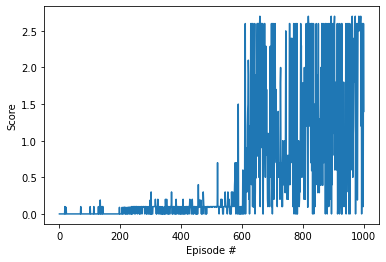

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()